In [7]:
%matplotlib inline

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Лабораторная работа №2, часть 2

In [9]:
from functools import partial, reduce
from itertools import chain, combinations_with_replacement, islice
from operator import mul
from typing import Iterable, NamedTuple, Optional, TypeVar

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from more_itertools import last
from nptyping import Array
from scipy.optimize import OptimizeResult, minimize
from scipy.special import comb, expit, xlog1py

from common import (
    cost,
    gradient_descent_regularized,
    hypothesis,
    learning_rate_gen,
    loss_convergence_display,
    loss_regularized,
)

## Загрузка данных

In [10]:
TEST_1_COLUMN_NAME = "test_1"
TEST_2_COLUMN_NAME = "test_2"
CONTROL_PASSED_COLUMN_NAME = "control_passed"

FEATURE_COLUMN_NAMES = (TEST_1_COLUMN_NAME, TEST_2_COLUMN_NAME)
FEATURE_COUNT = len(FEATURE_COLUMN_NAMES)

ParamType = np.single
ParamVector = Array[ParamType, 0, ...]
ParamMatrix = Array[ParamType, ..., ...]

DATA = pd.read_csv(
    "ex2data2.txt",
    header=None,
    names=[TEST_1_COLUMN_NAME, TEST_2_COLUMN_NAME, CONTROL_PASSED_COLUMN_NAME],
    dtype=ParamType,
)
EXAMPLE_COUNT = DATA.shape[0]

FEATURES = DATA[[TEST_1_COLUMN_NAME, TEST_2_COLUMN_NAME]].to_numpy()
TARGETS = DATA[CONTROL_PASSED_COLUMN_NAME].to_numpy()


## Отображение входных данных

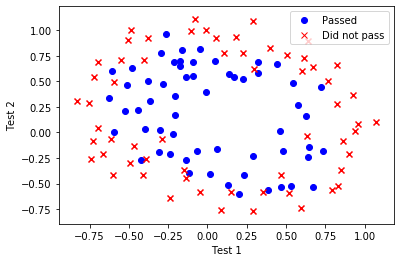

In [11]:
class ElementMarker(NamedTuple):
    marker: str
    color: str
    label: str


passed_marker = ElementMarker(marker="o", color="blue", label="Passed")
did_not_pass_marker = ElementMarker(marker="x", color="red", label="Did not pass")

legend_elements = [
    Line2D(
        [0],
        [0],
        marker=element_marker.marker,
        color="w",
        markerfacecolor=element_marker.color,
        markeredgecolor=element_marker.color,
        label=element_marker.label,
    )
    for element_marker in (passed_marker, did_not_pass_marker)
]

data_fig, data_axes = plt.subplots()

for row in DATA.itertuples():
    element_marker = passed_marker if row.control_passed else did_not_pass_marker
    data_axes.scatter(
        row.test_1, row.test_2, marker=element_marker.marker, c=element_marker.color
    )

data_axes.set_xlabel("Test 1")
data_axes.set_ylabel("Test 2")
data_axes.legend(handles=legend_elements, loc="upper right")
plt.show()

## Комбинации признаков

In [12]:
FeatureType = TypeVar("FeatureType")


def feature_combinations(
    features: Iterable[FeatureType], degree: int
) -> Iterable[FeatureType]:
    """
    Sum up polynomial with features up to the degree.
    """

    return chain.from_iterable(
        (reduce(mul, comb, 1) for comb in combinations_with_replacement(features, i))
        for i in range(degree + 1)
    )


def get_number_of_coefficients(n_features: int, degree: int) -> int:
    return sum(comb(2, i, repetition=True, exact=True) for i in range(degree + 1))


print(f"Initial feature set size: {FEATURE_COUNT}")

POLYNOMIAL_DEGREE = 6
print(f"Maximum polynomial degree: {POLYNOMIAL_DEGREE}")

EXTENDED_FEATURE_COUNT = get_number_of_coefficients(
    len(FEATURE_COLUMN_NAMES), POLYNOMIAL_DEGREE
)
print(f"Size of extended feature set: {EXTENDED_FEATURE_COUNT}")


Initial feature set size: 2
Maximum polynomial degree: 6
Size of extended feature set: 28


### Расширенный набор признаков

In [13]:
def extend_feature_set(features: ParamMatrix, degree: int) -> ParamMatrix:
    extended_features = np.fromiter(
        chain.from_iterable(feature_combinations(row, degree) for row in features),
        dtype=ParamType,
    )
    example_count, feature_count = features.shape
    extended_features.shape = (
        example_count,
        get_number_of_coefficients(feature_count, degree),
    )
    return extended_features


EXTENDED_FEATURES = extend_feature_set(FEATURES, POLYNOMIAL_DEGREE)
print(EXTENDED_FEATURES[:3])


[[ 1.00000000e+00  5.12670018e-02  6.99559987e-01  2.62830546e-03
   3.58643420e-02  4.89384174e-01  1.34745336e-04  1.83865731e-03
   2.50892602e-02  3.42353582e-01  6.90798970e-06  9.42624465e-05
   1.28625112e-03  1.75514426e-02  2.39496872e-01  3.54151922e-07
   4.83255326e-06  6.59422367e-05  8.99809820e-04  1.22782867e-02
   1.67542428e-01  1.81563067e-08  2.47750506e-07  3.38066093e-06
   4.61305499e-05  6.29470916e-04  8.58939812e-03  1.17205977e-01]
 [ 1.00000000e+00 -9.27420035e-02  6.84939981e-01  8.60107876e-03
  -6.35227039e-02  4.69142765e-01 -7.97681336e-04  5.89122297e-03
  -4.35092412e-02  3.21334630e-01  7.39785610e-05 -5.46363823e-04
   4.03513433e-03 -2.98012178e-02  2.20094949e-01 -6.86092017e-06
   5.06708748e-05 -3.74226423e-04  2.76382477e-03 -2.04120465e-02
   1.50751829e-01  6.36295511e-07 -4.69931865e-06  3.47065070e-05
  -2.56322644e-04  1.89305411e-03 -1.39810266e-02  1.03255957e-01]
 [ 1.00000000e+00 -2.13709995e-01  6.92250013e-01  4.56719622e-02
  -1.479

### Представление гипотезы
$$
\begin{equation}
\large
h_{\theta}(x) = g(\theta^{T}x)
\end{equation}
$$

$$
\begin{equation}
g(z) = \dfrac{1}{1 + e^{-z}}
\end{equation}
$$

In [14]:
??hypothesis
assert np.array_equal(
    np.ones(3), hypothesis(np.repeat(float("inf"), 3), np.ones((3, 3)))
)

### Функция стоимости для элемента
$$
\begin{align*}
\mathrm{Cost}(h_{\theta}(x), y) = -\log(h_{\theta}(x)) \; \text{ где y = 1 }\\
\mathrm{Cost}(h_{\theta}(x), y) = -\log(1 - h_{\theta}(x)) \; \text{ где y = 0 }
\end{align*}
$$

или

$$
\begin{align*}
\normalsize
\mathrm{Cost}(h_{\theta}(x), y) =
-y\log(h_{\theta}(x)) - (1 - y) \log(1 - h_{\theta}(x))
\end{align*}
$$

In [15]:
??cost
assert np.array_equal(np.zeros(3), cost(np.ones(3), np.ones(3)))

### Полная регуляризованная функция стоимости
$$
\begin{equation}
\large
J(\theta) = \dfrac{1}{m} \sum_{i=0}^{m} \mathrm{Cost}(h_{\theta}(x^{(i)}, y^{(i)}) =\\
= -\dfrac{1}{m} \sum_{i=0}^{m}
\left[
y^{(i)}\log(h_{\theta}(x^{(i)}))
+ (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)}))
+ \dfrac{\lambda}{2m} \sum_{j=1}^{n} \theta^{2}_{j=1}
\right]
\end{equation}
$$

In [16]:
??loss_regularized

### Грандиентный спуск
$$
\begin{equation}
\large
\theta_j := \theta_j - \frac{\alpha}{m}
\left[
\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}
+ \lambda \theta_j
\right]
\end{equation}
$$
??gradient_descent_regularized

In [17]:
assert np.allclose(
    np.repeat(1e10, 3),
    next(
        gradient_descent_regularized(
            1, 0, np.repeat(1e10, 3), np.ones((3, 3)), np.ones(3)
        )
    ),
)


## Поиск оптимального значения скорости обучения

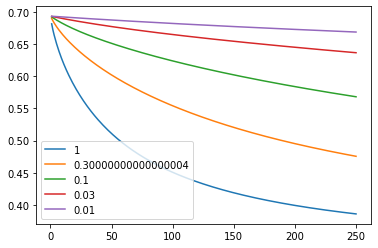

In [18]:
THETA_START = np.zeros(EXTENDED_FEATURE_COUNT)

loss_for_theta = partial(loss_regularized, x=EXTENDED_FEATURES, y=TARGETS, reg_param=0)
gradient_descent_for_learning_rate = partial(
    gradient_descent_regularized,
    reg_param=0,
    theta=THETA_START,
    x=EXTENDED_FEATURES,
    y=TARGETS,
)

learning_rate_fig, learning_rate_axes = plt.subplots()
for rate in islice(learning_rate_gen(1), 5):
    loss_convergence_display(
        learning_rate_axes,
        rate,
        thetas=gradient_descent_for_learning_rate(rate),
        loss_for_theta=loss_for_theta,
        max_iterations=250,
    )

# Оптимальное значение
LEARNING_RATE = ParamType(1)

plt.legend()
plt.show()


## Поиск решения

In [19]:
REG_PARAM = ParamType("0.2")

iterations, gradient_theta = last(
    enumerate(
        islice(
            gradient_descent_regularized(
                LEARNING_RATE, REG_PARAM, THETA_START, x=EXTENDED_FEATURES, y=TARGETS
            ),
            100000,
        ),
        1,
    )
)
print(f"iterations = {iterations}")
print(f"theta = {gradient_theta}")
print(
    f"loss = {loss_regularized(gradient_theta, EXTENDED_FEATURES, TARGETS, REG_PARAM)}"
)


iterations = 17835
theta = [ 2.30527294  1.4692725   2.39021708 -3.61912767 -2.48951573 -3.25548985
  0.51319106 -0.8816411  -0.6012717  -0.29294485 -2.71622139  0.17515768
 -1.35451836 -0.85270708 -2.26346781 -0.44505425 -0.41305415  0.22134904
 -0.76170358 -0.83670758 -0.35703654 -2.05642634  0.24259364 -0.59926749
  0.19223227 -0.79484777 -0.58611129 -1.26034287]
loss = 0.4323798779999341


### Построение разделяющей прямой

In [20]:
def legend_handle(color: Optional[str] = None, label: Optional[str] = None) -> Line2D:
    return Line2D([0], [0], color=color, label=label)


def display_decision_boundary(
    ax: Axes,
    grid_steps: int,
    theta: ParamVector,
    x1_values: ParamVector,
    x2_values: ParamVector,
    color=None,
):
    hypotheses = np.empty((grid_steps, grid_steps), dtype=ParamType)
    for i, x1 in enumerate(x1_values):
        for j, x2 in enumerate(x2_values):
            hypotheses[i, j] = theta @ np.fromiter(
                feature_combinations((x1, x2), POLYNOMIAL_DEGREE), dtype=ParamType
            )
    ax.contour(x1_values, x2_values, hypotheses, 0, colors=color)


GRID_STEPS = 100
VALUES_OFFSET = ParamType("0.3")

x1_min = min(FEATURES[:, 0])
x1_max = max(FEATURES[:, 0])
x1_values = np.linspace(x1_min - VALUES_OFFSET, x1_max + VALUES_OFFSET, num=GRID_STEPS)

x2_min = min(FEATURES[:, 1])
x2_max = max(FEATURES[:, 1])
x2_values = np.linspace(x2_min - VALUES_OFFSET, x2_max + VALUES_OFFSET, num=GRID_STEPS)

decision_boundary_for_theta = partial(
    display_decision_boundary,
    grid_steps=GRID_STEPS,
    x1_values=x1_values,
    x2_values=x2_values,
)

### Разделяющая прямая для регуляризованного градиентного спуска

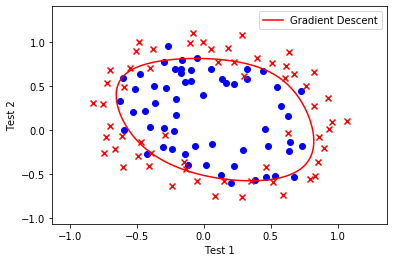

In [21]:
color = "red"
label = "Gradient Descent"
decision_boundary_for_theta(ax=data_axes, theta=gradient_theta, color=color)
data_axes.legend(handles=[legend_handle(color, label)])
data_fig


### Функиця предсказания

In [22]:
def predict(theta: ParamVector, x: ParamMatrix) -> ParamMatrix:
    return (x @ theta) >= ParamType("0.5")


def get_score(predictions: ParamVector, targets: ParamVector) -> float:
    length = len(predictions)
    assert length == len(targets)
    return sum(predictions == targets) / length


gradient_score = get_score(
    predict(gradient_theta, EXTENDED_FEATURES), TARGETS.astype(np.bool)
)
print(f"Gradient descent score = {gradient_score:.1%}")


Gradient descent score = 80.5%


### Отображение результатов оптимизации

In [23]:
def display_optimization(optimize_result: OptimizeResult, ax: Axes, color=None):
    print(f"iterations = {optimize_result.nit}")
    print(f"theta = {optimize_result.x}")
    print(f"loss = {optimize_result.fun}")
    score = get_score(predict(optimize_result.x, EXTENDED_FEATURES), TARGETS)
    print(f"score = {score:.1%}")
    decision_boundary_for_theta(ax=ax, theta=optimize_result.x, color=color)


## Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно с ограниченной памятью

iterations = 88
theta = [ 2.19596969  1.42860647  2.35325359 -3.43727284 -2.46419648 -3.04876851
  0.52827756 -0.88908551 -0.59459219 -0.28199028 -2.71012913  0.19115158
 -1.37465274 -0.83060042 -2.25981253 -0.44540862 -0.41400626  0.21706116
 -0.76942782 -0.8292114  -0.37447164 -2.07625658  0.25309721 -0.61571488
  0.20075359 -0.81234224 -0.56918865 -1.29882447]
loss = 0.4321655069705024
score = 81.4%


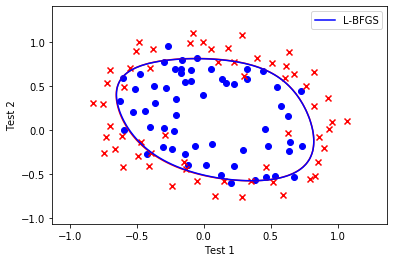

In [24]:
color = "blue"
label = "L-BFGS"
l_bfgs_optimization = minimize(
    fun=loss_regularized,
    x0=THETA_START,
    args=(EXTENDED_FEATURES, TARGETS, REG_PARAM),
    method="BFGS",
    tol=ParamType("1e-6"),
)
display_optimization(l_bfgs_optimization, data_axes, color=color)
data_axes.legend(handles=[legend_handle(color, label)])
data_fig


## Влияние регуляризационного параметра на результаты

Regularization parameter: 0.00
iterations = 1163
theta = [   29.97986829    43.70816272    71.81819127  -292.30645018
  -153.26171654  -147.44669064  -292.27903524  -641.98291662
  -548.00763938  -365.01536909   949.63273642  1070.49293667
  1499.17947937   749.09163216   375.61306601   464.35536703
  1282.87414267  1988.65613621  2195.75941672  1336.17777123
   559.72150422 -1024.87434826 -1860.6368024  -3275.56570178
 -3410.85409968 -3257.93693483 -1594.31681668  -541.48068281]
loss = 0.22108326378204665
score = 86.4%
Regularization parameter: 0.20
iterations = 88
theta = [ 2.19596969  1.42860647  2.35325359 -3.43727284 -2.46419648 -3.04876851
  0.52827756 -0.88908551 -0.59459219 -0.28199028 -2.71012913  0.19115158
 -1.37465274 -0.83060042 -2.25981253 -0.44540862 -0.41400626  0.21706116
 -0.76942782 -0.8292114  -0.37447164 -2.07625658  0.25309721 -0.61571488
  0.20075359 -0.81234224 -0.56918865 -1.29882447]
loss = 0.4321655069705024
score = 81.4%
Regularization parameter: 10.00
itera

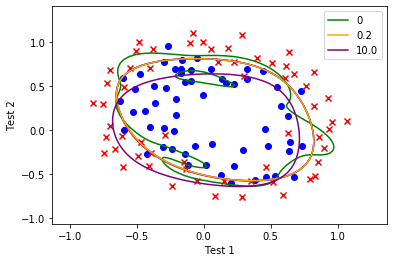

In [25]:
class RegParamColor(NamedTuple):
    value: ParamType
    color: str


params = (
    RegParamColor(0, "green"),
    RegParamColor(ParamType("0.2"), "orange"),
    RegParamColor(ParamType("10"), "purple"),
)
for reg_param, color in params:
    print(f"Regularization parameter: {reg_param:.2f}")
    optimization = minimize(
        fun=loss_regularized,
        x0=THETA_START,
        args=(EXTENDED_FEATURES, TARGETS, reg_param),
        method="BFGS",
        tol=ParamType("1e-6"),
    )
    display_optimization(optimization, data_axes, color=color)
    print("=" * 10)

data_axes.legend(
    handles=[legend_handle(p.color, str(p.value)) for p in params], loc="upper right"
)
data_fig